# Домашнее задание №4 по МОМО

## 1) Импорт библиотек

In [1]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import matplotlib # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации

from sklearn.cluster import KMeans # Модель кластеризации К-средних

from sklearn.preprocessing import StandardScaler # Нормализация
from sklearn.preprocessing import LabelEncoder# Импортируем LabelEncoder от scikit-learn

from sklearn.metrics import f1_score # метрика F1
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # метрики для классификации категориального признака
from sklearn.metrics import silhouette_samples # метрика коэффициент силуэта
from sklearn.metrics import classification_report # функция scikit-learn которая считает много метрик классификации

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.style.use('dark_background')

## 2) Загрузка данных

Набор данных представляет собой параметры пингвинов для выполнения кластеризации. Данные взяты с платформы [Kaggle](https://www.kaggle.com/datasets/youssefaboelwafa/clustering-penguins-species).\
Данные содержат следующие колонки:

1) culmen_length_mm: длина надклювья (мм)
2) culmen_depth_mm: глибина надклювья (мм)
3) flipper_length_mm: длина ласта (мм)
4) body_mass_g: масса тела пингвина (г)
4) sex: пол пингвина

Загрузим и посмотрим на данные:

In [4]:
# https://www.kaggle.com/datasets/youssefaboelwafa/clustering-penguins-species
df = pd.read_csv('penguins.csv')
df.head(5)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


## 3) Разведывательный анализ данных (EDA)

In [5]:
# Рассмотрим общую информацию о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


In [6]:
# Проверим наличие пропусков
df.isna().sum()

culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
sex                  9
dtype: int64

Имеются 2 пропущенные записи в характеристиках тела пингвина и 9 пропущенных записей пола пингвина. Удалим эти 2 пропущенные записи, а 9 пропущенных записей пола оставим, т.к. кластеризация будет основана на числовых характеристиках и попробуем с помощью кластеризации классифицировать эти пропущенные записи пола.

In [7]:
df = df.dropna(subset = ['culmen_length_mm'])
df.isna().sum()

culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  7
dtype: int64

In [8]:
# Проверим наличие и количество дубликатов
df.duplicated().sum()

0

Теперь дубликатов и пропусков нет.

In [9]:
df.sample(3)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
230,40.9,13.7,214.0,4650.0,FEMALE
62,37.6,17.0,185.0,3600.0,FEMALE
100,35.0,17.9,192.0,3725.0,FEMALE


### Проведем анализ признаков
Посмотрим какие категориальные и численные столбцы

In [10]:
cat_columns = [] # создаем пустой список для имен колонок категориальных данных
num_columns = [] # создаем пустой список для имен колонок числовых данных

for column_name in df.columns: # смотрим на все колонки в датафрейме
    if (df[column_name].dtypes == object): # проверяем тип данных для каждой колонки
        cat_columns +=[column_name] # если тип объект - то складываем в категориальные данные
    else:
        num_columns +=[column_name] # иначе - числовые

# важно: если признак категориальный, но хранится в формате числовых данных, тогда код не сработает корректно


# выводим результат
print('Категориальные данные:\t ',cat_columns, '\n Число столбцов = ',len(cat_columns))

print('Числовые данные:\t ',  num_columns, '\n Число столбцов = ',len(num_columns))


Категориальные данные:	  ['sex'] 
 Число столбцов =  1
Числовые данные:	  ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g'] 
 Число столбцов =  4


#### а) Анализ числовых признаков

In [11]:
# посчитаем стандартные статистические характеристики для числовых данных
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,214.014620,4201.754386
std,5.459584,1.974793,260.558057,801.954536
min,32.100000,13.100000,-132.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.750000,4750.000000
max,59.600000,21.500000,5000.000000,6300.000000


Отрицательная длина ласта -132мм и слишком большая длина ласта 5000мм являются явно выбросами. Избавимся от этих значений:

In [12]:
# Посмотрим на распределение
df['flipper_length_mm'].value_counts()

 190.0     21
 195.0     17
 187.0     16
 193.0     15
 210.0     14
 191.0     13
 215.0     12
 196.0     10
 197.0     10
 185.0      9
 208.0      8
 220.0      8
 216.0      8
 198.0      7
 230.0      7
 186.0      7
 212.0      7
 192.0      7
 181.0      7
 184.0      7
 189.0      7
 199.0      6
 217.0      6
 213.0      6
 214.0      6
 188.0      6
 201.0      6
 222.0      6
 180.0      5
 221.0      5
 194.0      5
 203.0      5
 218.0      5
 219.0      5
 209.0      5
 178.0      4
 202.0      4
 225.0      4
 228.0      4
 200.0      4
 205.0      3
 224.0      3
 182.0      3
 223.0      2
 229.0      2
 211.0      2
 207.0      2
 183.0      2
 231.0      1
-132.0      1
 5000.0     1
 206.0      1
 176.0      1
 174.0      1
 179.0      1
 172.0      1
 226.0      1
Name: flipper_length_mm, dtype: int64

In [13]:
df = df.drop(df[df['flipper_length_mm'] == -132].index)
df = df.drop(df[df['flipper_length_mm'] == 5000].index)
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,340.000000,340.000000,340.000000,340.000000
mean,43.955000,17.130588,200.955882,4201.029412
std,5.451108,1.961880,14.089719,804.240035
min,32.100000,13.100000,172.000000,2700.000000
25%,39.275000,15.575000,190.000000,3550.000000
50%,44.500000,17.300000,197.000000,4025.000000
75%,48.500000,18.625000,213.250000,4756.250000
max,59.600000,21.500000,231.000000,6300.000000


In [14]:
# Посмотрим на корреляцию числовых столбцов
df[num_columns].corr().style.background_gradient(cmap = 'YlOrRd', vmin = -1, vmax=1) 

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.226532,0.657898,0.599159
culmen_depth_mm,-0.226532,1.000000,-0.585176,-0.478214
flipper_length_mm,0.657898,-0.585176,1.000000,0.872404
body_mass_g,0.599159,-0.478214,0.872404,1.000000


Согласно таблице корреляции отсутсвуют явнозависимые друг от друга признаки. Поэтому все числовые признаки будут участвовать в кластеризации.

**Гистограммы распределений**

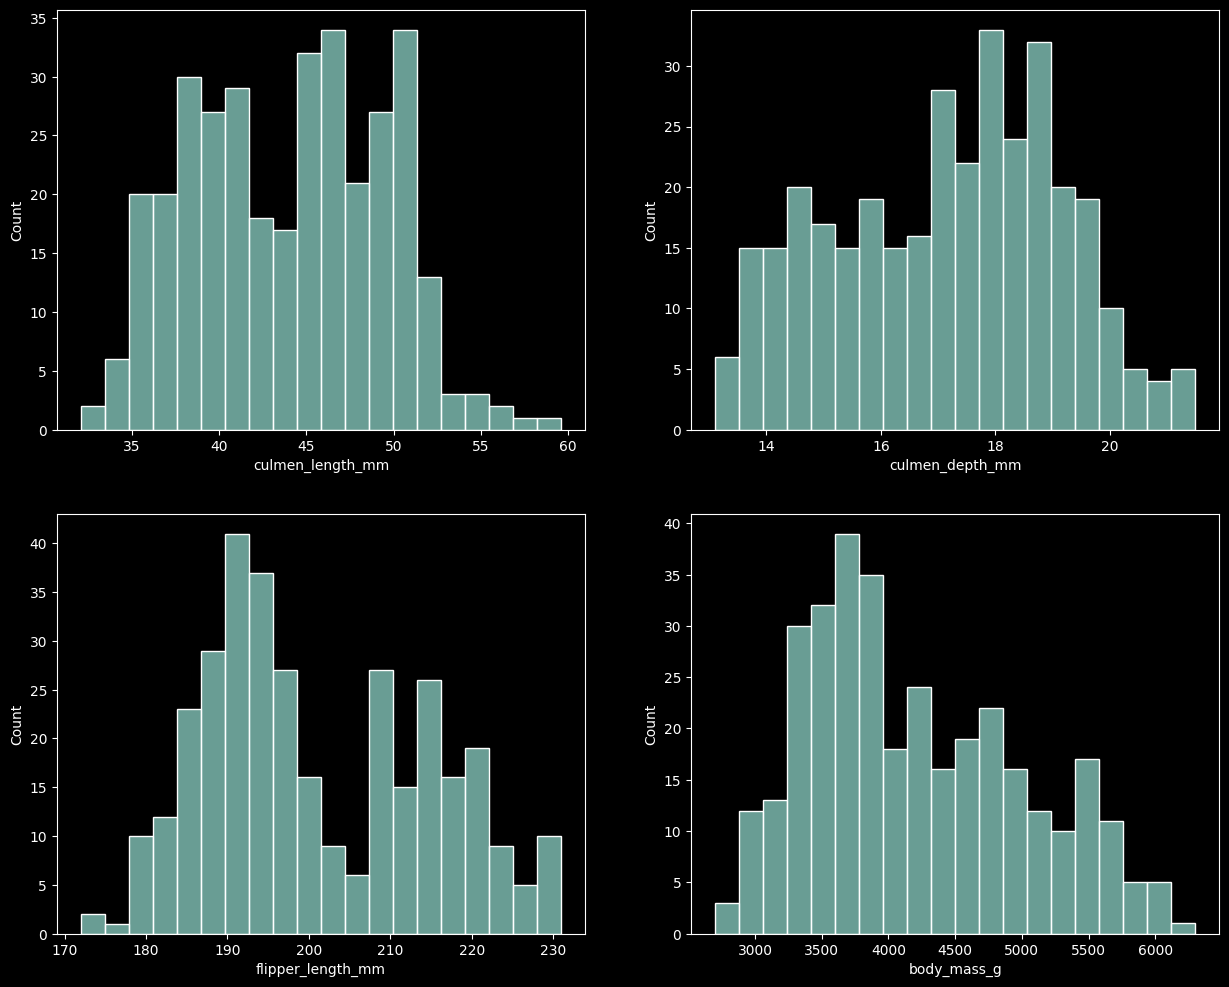

In [15]:
width = 2
height = int(np.ceil(len(num_columns) / width))
fig, ax = plt.subplots(nrows=height, ncols=width, figsize=(15, 12)) # создаем "полотно", на котором будем "рисовать" графики
#     ↑  более точная структура (почти синоним subplot). Говорим что у нас будет height строк и width столбцов

for idx, column_name in enumerate(num_columns): # перебираем все числовые данные
    plt.subplot(height, width, idx + 1) # берем конкретную ячейку из заранее подготовленную заготовки
    # рисуем с помощью библиотеки seaborn
    sns.histplot(data=df, x=column_name, bins = 20); 

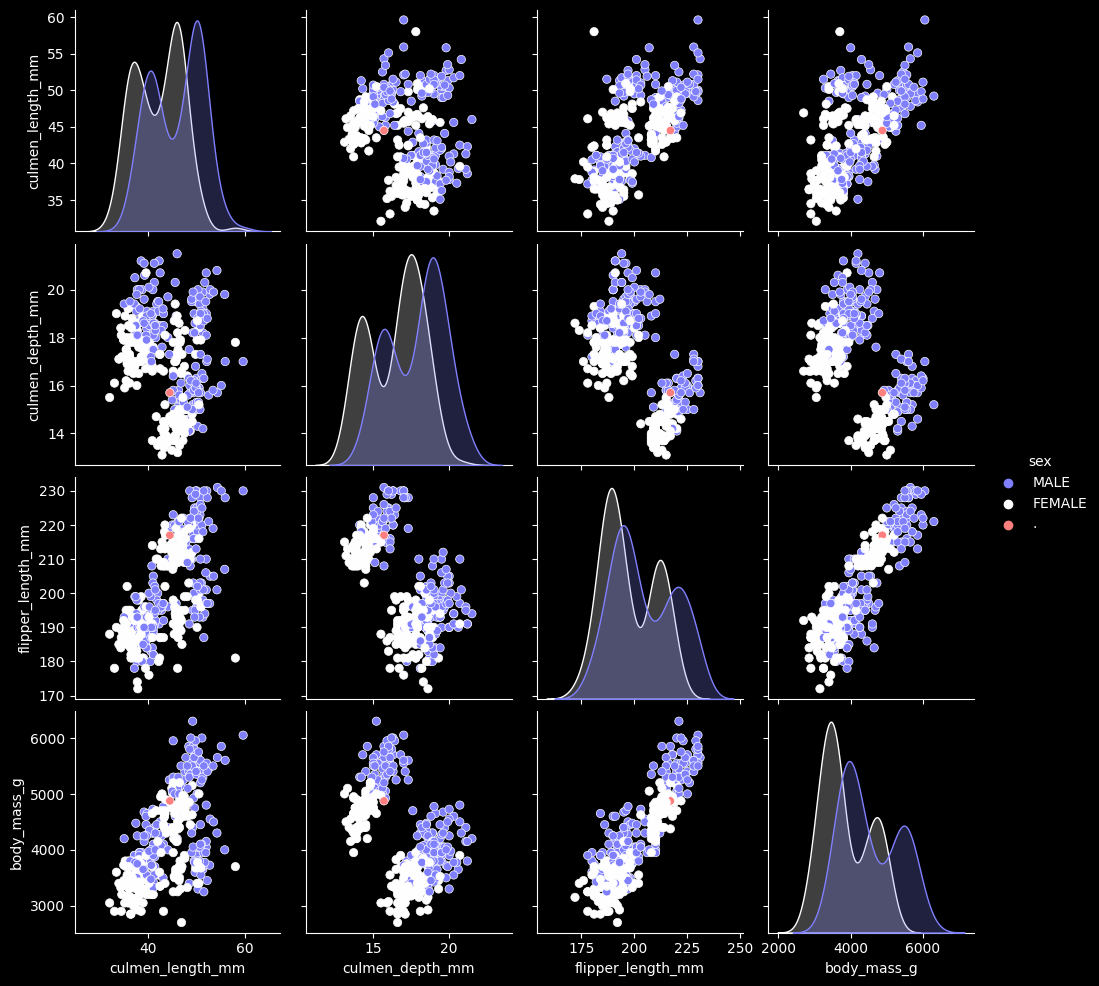

In [16]:
sns.pairplot(data=df, hue='sex', palette='bwr')

## 4) Предварительная обработка данных

In [17]:
# Стандартизируем числовые признаки
df_cluster = df[num_columns]
df_cluster.head(5)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0


**Выполним стандартизацию признаков**

In [18]:
scaler = StandardScaler()
scaler.fit(df_cluster)
scaler.mean_, scaler.scale_ # запишем матожидение с среднеквадратичное отклонение

(array([  43.955     ,   17.13058824,  200.95588235, 4201.02941176]),
 array([  5.4430856 ,   1.95899275,  14.06898322, 803.05645854]))

In [19]:
df_cluster = scaler.transform(df_cluster)
df_cluster = pd.DataFrame(df_cluster, columns = num_columns)
df_cluster.head(5)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,-0.891957,0.801132,-1.418431,-0.561641
1,-0.818470,0.137526,-1.063039,-0.499379
2,-0.671494,0.443806,-0.423334,-1.184262
3,-1.332884,1.107412,-0.565491,-0.935214
4,-0.855213,1.771018,-0.778726,-0.686165


## 5) Кластеризация k-Means (к-средних)

Создадим функции-помощники

In [20]:
def plot_silhouette_results(X,centroids,labels, label_centroids, axis_x, axis_y):
    """Визуализация результатов кластеризации и коэффициентов силуэта
    Входные переменные:
    ===========
    X: признаки
    centroids: центры кластеров
    labels: метки кластеров для данных
    centroids: метки центров кластеров
    axis_x: какую ось рисовать в качестве Х
    axis_y: какую ось рисовать в качестве У
    """

    # создаем большое полотно
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(25  , 5)

    # считаем коэффициенты силуэта через функцию scikit-learn
    silhouette_vals = silhouette_samples(X, labels)

    # выбираем цветовую карту - мне нравится 'bwr'
    cmap = matplotlib.colormaps['bwr']
    y_lower, y_upper = 0, 0
    # перебираем все метки кластеров
    for i, cluster in enumerate(np.unique(labels)):
        # отбираем коэффициент силуэта для текущей метки
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        # сортируем
        cluster_silhouette_vals.sort()

        # визуализируем
        # определяем верхнюю границу рисования (по вертикали
        y_upper += len(cluster_silhouette_vals)  # как количество объектов с текущей меткой
        c = cluster /max(labels) # считаем "координату" метки кластера в цветовой карте
        # с помощью горизонтальных полос визуализируем коэффициенты силуэта
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals,color = cmap(c), edgecolor='none', height=1)
        # "слева" напишем номер метки кластеров
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        # переопределим нижнюю границу рисования  (по вертикали)
        y_lower += len(cluster_silhouette_vals)  # (предыдущая верхняя граница)

    # оцениваем среднее значение коэффициента силлуэта
    avg_score = np.mean(silhouette_vals)
    # визуализируем через вертикальную линию
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Коэффициент Силуэта')
    ax1.set_ylabel('Кластеры')


    # визуализируем данные с подракашиванием
    # сначала сами данные
    ax2.scatter(X[:, axis_x], X[:, axis_y], c=labels, alpha = 0.7,  cmap = 'bwr',)
    # а потом центры кластеров, но большими кругами
    ax2.scatter(centroids[:, axis_x], centroids[:, axis_y], c=label_centroids, cmap = 'bwr', edgecolors = 'k', s=400)
    ax2.set_xlabel(new_names[axis_x])
    ax2.set_ylabel(new_names[axis_y])
    ax2.set_aspect('equal')
    plt.tight_layout();

In [21]:
def plot_multi(data, y,  names, sub, size):
    axis = [[0,1],
            [2,1],
            [0,3],
            [2,3],]
    

    labels = [['',names[1]],
            ['',''],
            [names[0],names[3]],
            [names[2],'']]


    for n, (axi, label, ax) in enumerate(zip(axis,  labels, sub.flatten())):
        scatter = ax.scatter(data[:,axi[0]],data[:,axi[1]],
                             c=y, s = size, cmap = 'bwr',
                             alpha = 0.7, facecolors = 'none' );
        ax.set_ylabel(label[1], fontsize = 20)
        ax.set_xlabel(label[0], fontsize = 20)
        ax.tick_params(axis='x', labelsize= 15)
        ax.tick_params(axis='y', labelsize= 15)
        ax.grid()
        legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters",
                        fontsize = 15)
        ax.add_artist(legend1)

### Визуализация кластеров (n_cluster = 2)

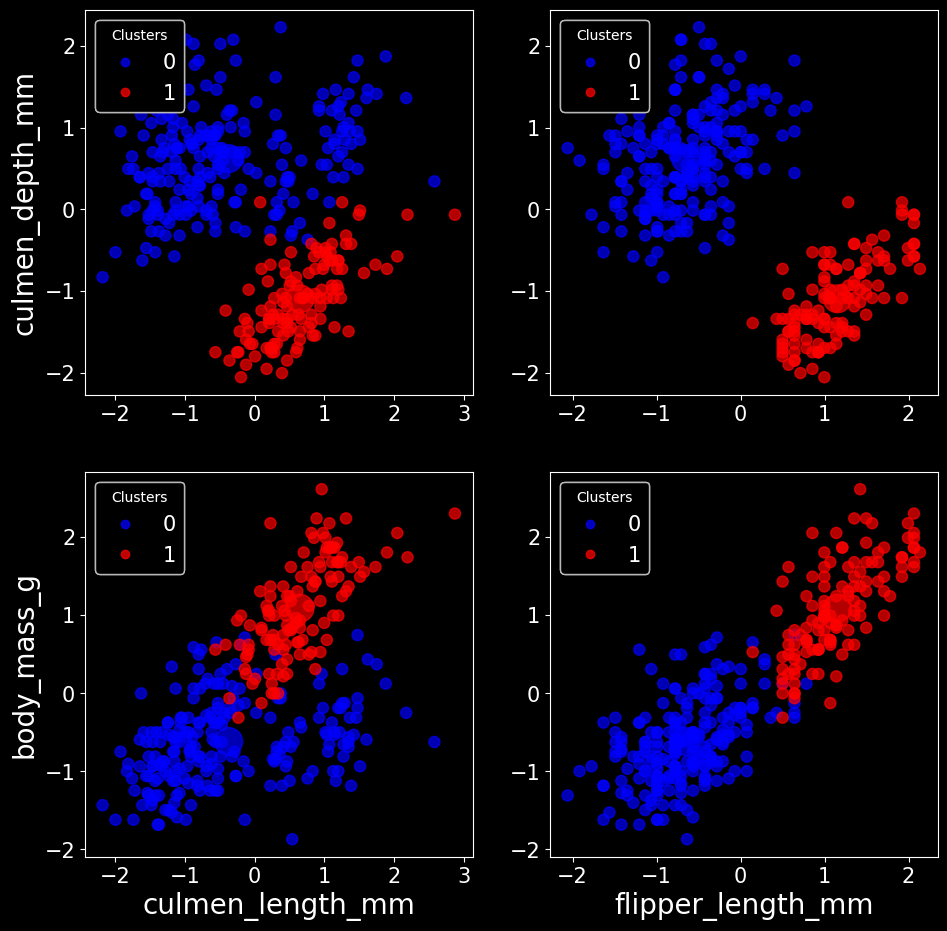

In [22]:
k = 2
X = np.array(df_cluster)
column_labels = df_cluster.columns
new_names = num_columns

# создаем объект
km = KMeans(n_clusters=k, n_init = 10)

# обучаем на данных
km.fit(X)
# предсказываем метки кластеров для данных
labels = km.predict(X)
# "забираем" координаты центров
centroids = km.cluster_centers_
# предсказываем метки для центроидов
label_centroids = km.predict(centroids)

#Визуализация 4-х проекций данных
fig, sub = plt.subplots(2, 2, figsize = (11,11))
plot_multi(X, labels,
           column_labels,
           sub, size = 64);


plot_multi(centroids, label_centroids,
           column_labels,
           sub, size = 400);

### Визуализация кластеров (n_cluster = 3)

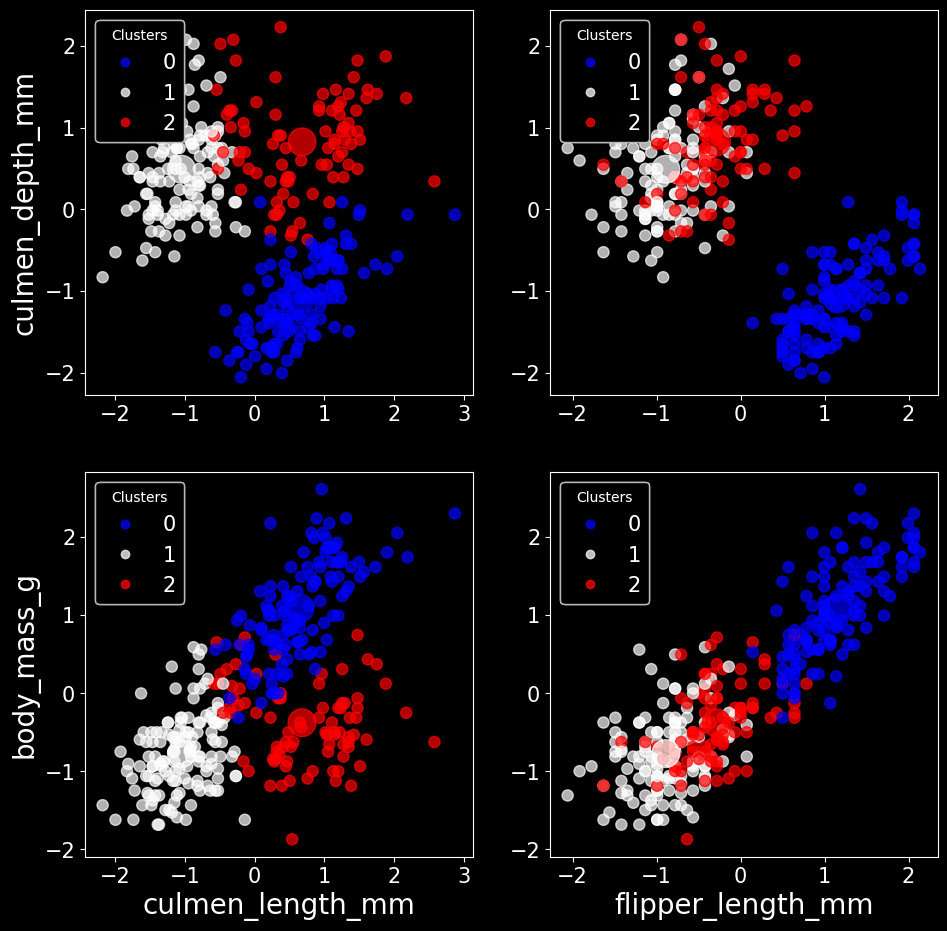

In [23]:
k = 3
# создаем объект
km = KMeans(n_clusters=k, n_init = 10)

# обучаем на данных
km.fit(X)
# предсказываем метки кластеров для данных
labels = km.predict(X)
# "забираем" координаты центров
centroids = km.cluster_centers_
# предсказываем метки для центроидов
label_centroids = km.predict(centroids)

#Визуализация 4-х проекций данных
fig, sub = plt.subplots(2, 2, figsize = (11,11))
plot_multi(X, labels,
           column_labels,
           sub, size = 64);


plot_multi(centroids, label_centroids,
           column_labels,
           sub, size = 400);

### Визуализация кластеров (n_cluster = 4)

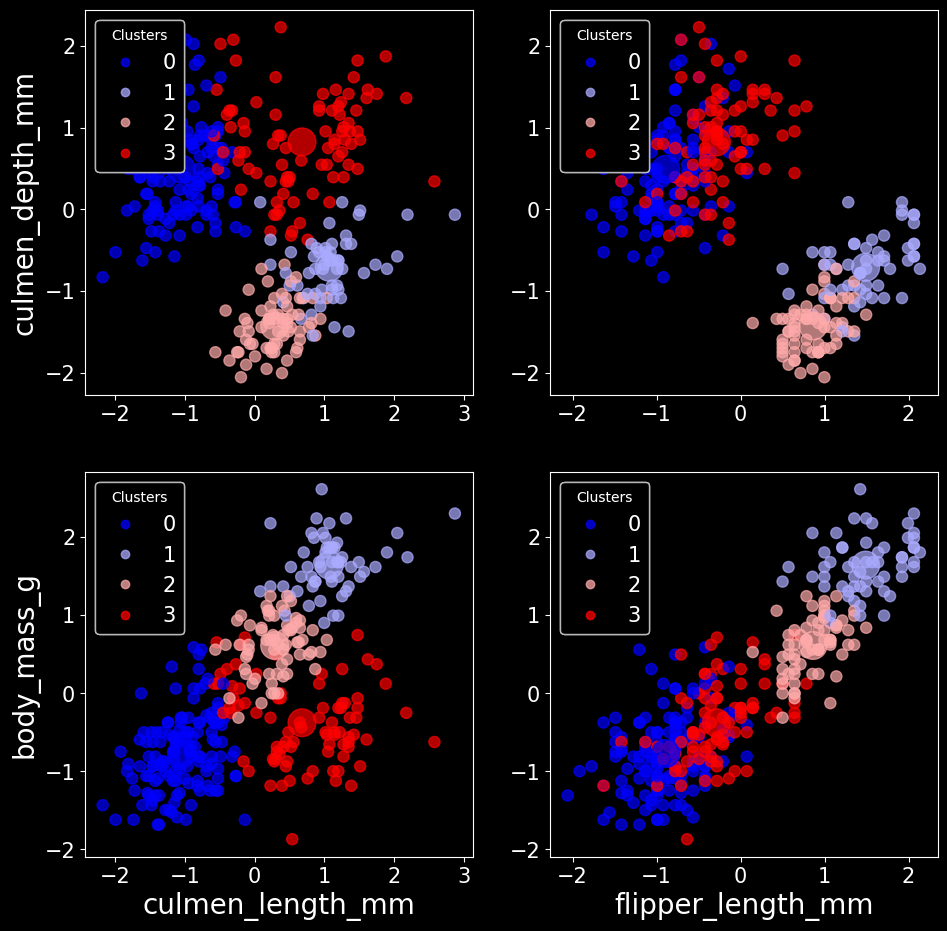

In [24]:
k = 4
# создаем объект
km = KMeans(n_clusters=k, n_init = 10)

# обучаем на данных
km.fit(X)
# предсказываем метки кластеров для данных
labels = km.predict(X)
# "забираем" координаты центров
centroids = km.cluster_centers_
# предсказываем метки для центроидов
label_centroids = km.predict(centroids)

#Визуализация 4-х проекций данных
fig, sub = plt.subplots(2, 2, figsize = (11,11))
plot_multi(X, labels,
           column_labels,
           sub, size = 64);


plot_multi(centroids, label_centroids,
           column_labels,
           sub, size = 400);

#### Выводы:
1) графики распределения "culmen_length_mm/culmen_depth_mm" и "culmen_length_mm/body_mass_g" показывают, что данные разбиты на 3 кластера;
2) график "flipper_length_mm/culmen_depth_mm" явно разбит на 2 кластера

### Метод "Локтя"

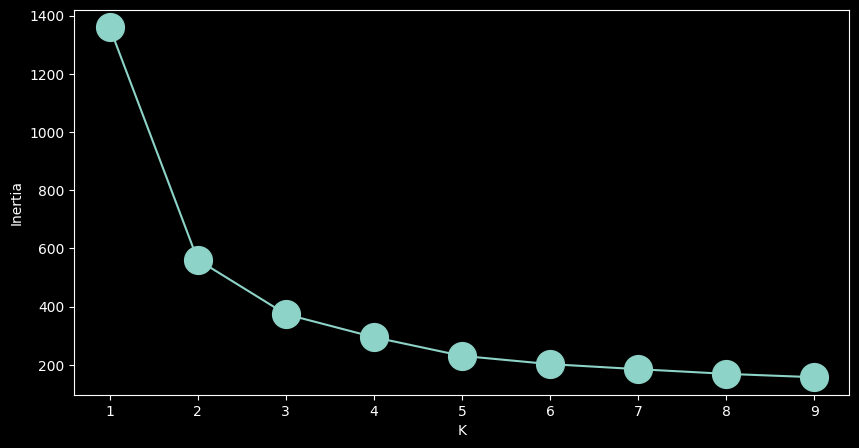

In [25]:
X = np.array(df_cluster)

sse = [] # здесь будем хранить инерции для конкретных к
list_k = list(range(1, 10))
for k in list_k: # тестируем различные к в диапазоне от 1 до 10
    km = KMeans(n_clusters=k, # создаем объект кластеризации с заданным к
            n_init = 10)
    km.fit(X) # обучаем
    sse.append(km.inertia_) # фиксируем текущую инерцию

# визуализируем метод локтя

plt.figure(figsize=(10, 5))
plt.plot(list_k, sse, '-o', markersize = 20)
plt.xlabel('K')
plt.ylabel('Inertia');

#### Выводы:
1) метод "локтя" тоже показывает, что кластеров должно быть 2 или 3.

### Коэффициент силуэта для реультатов кластеризации

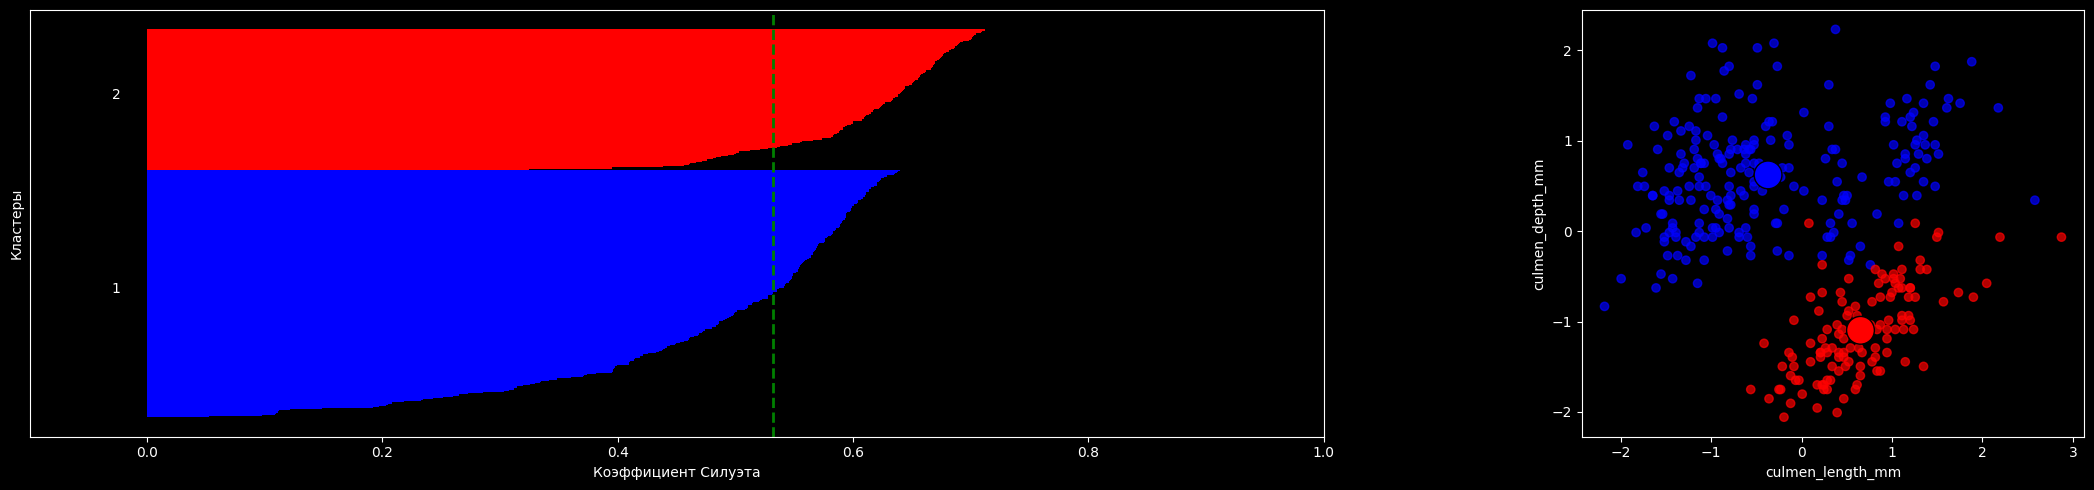

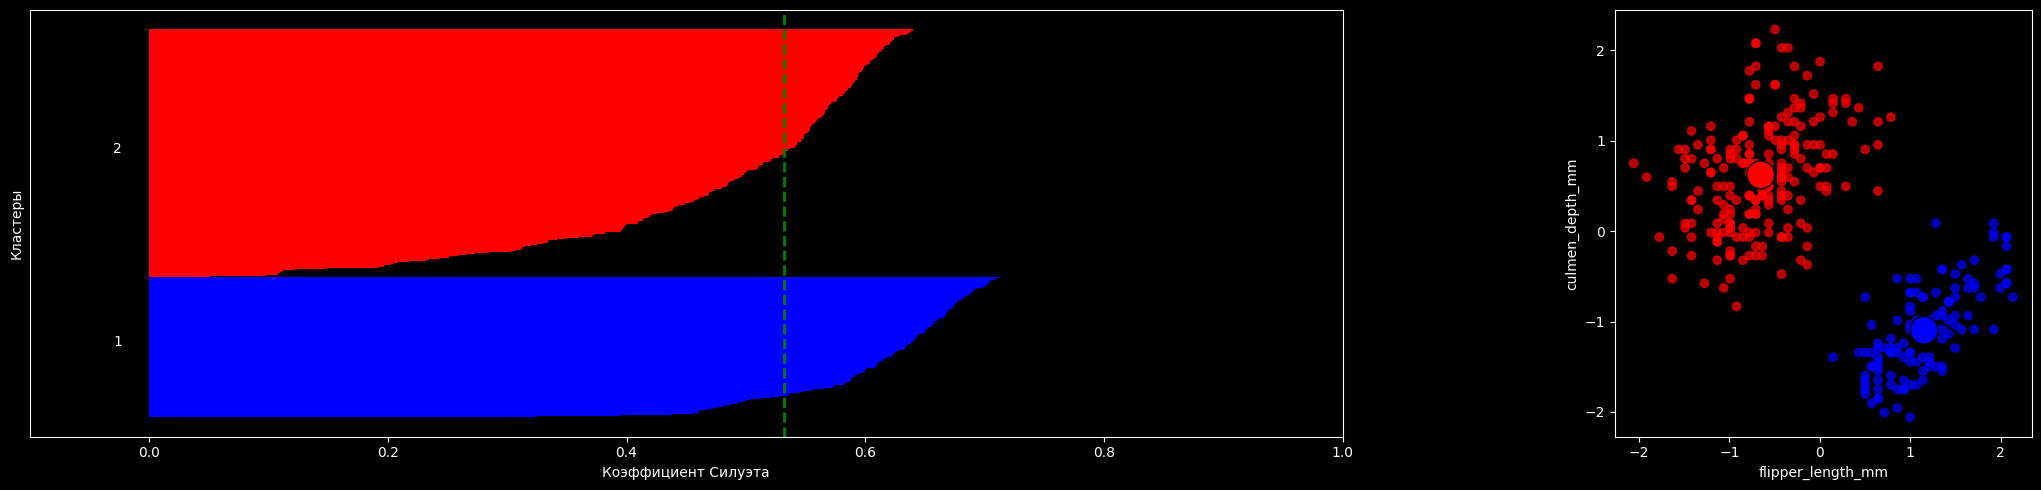

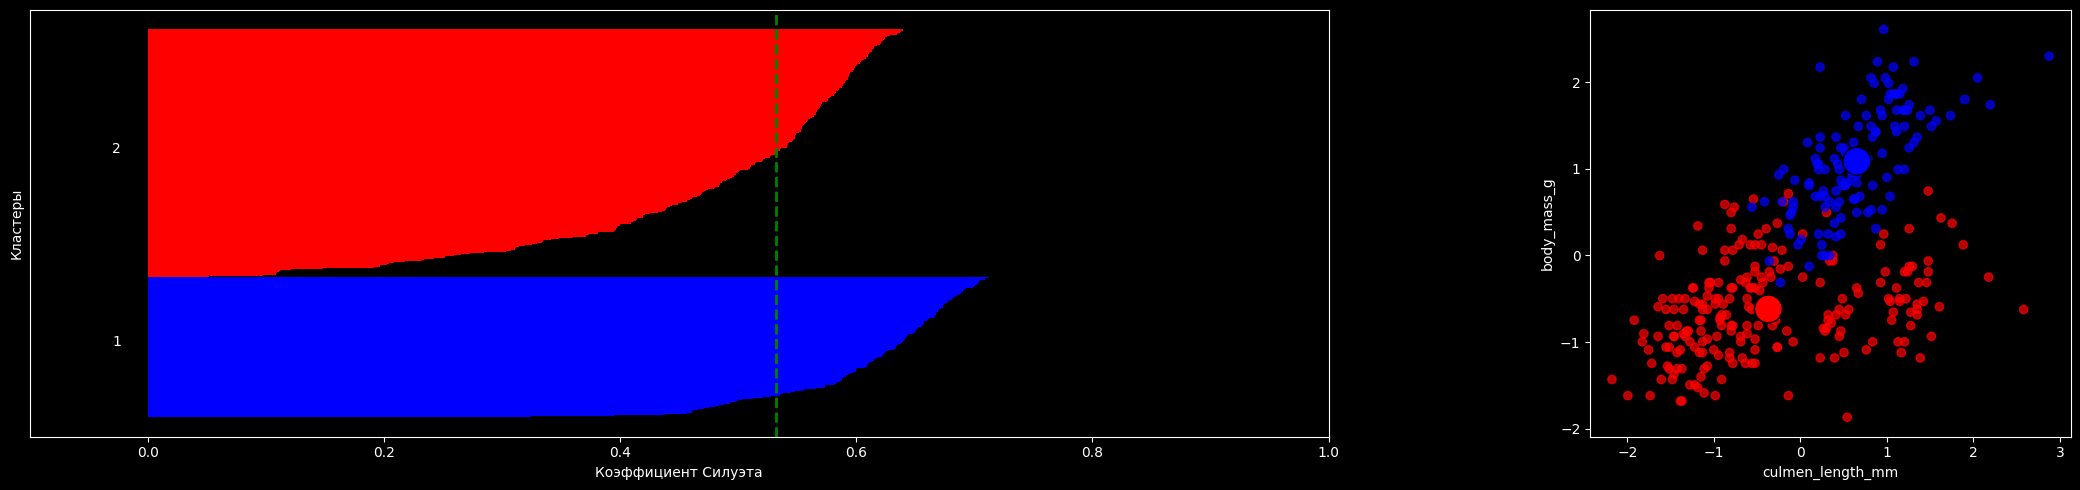

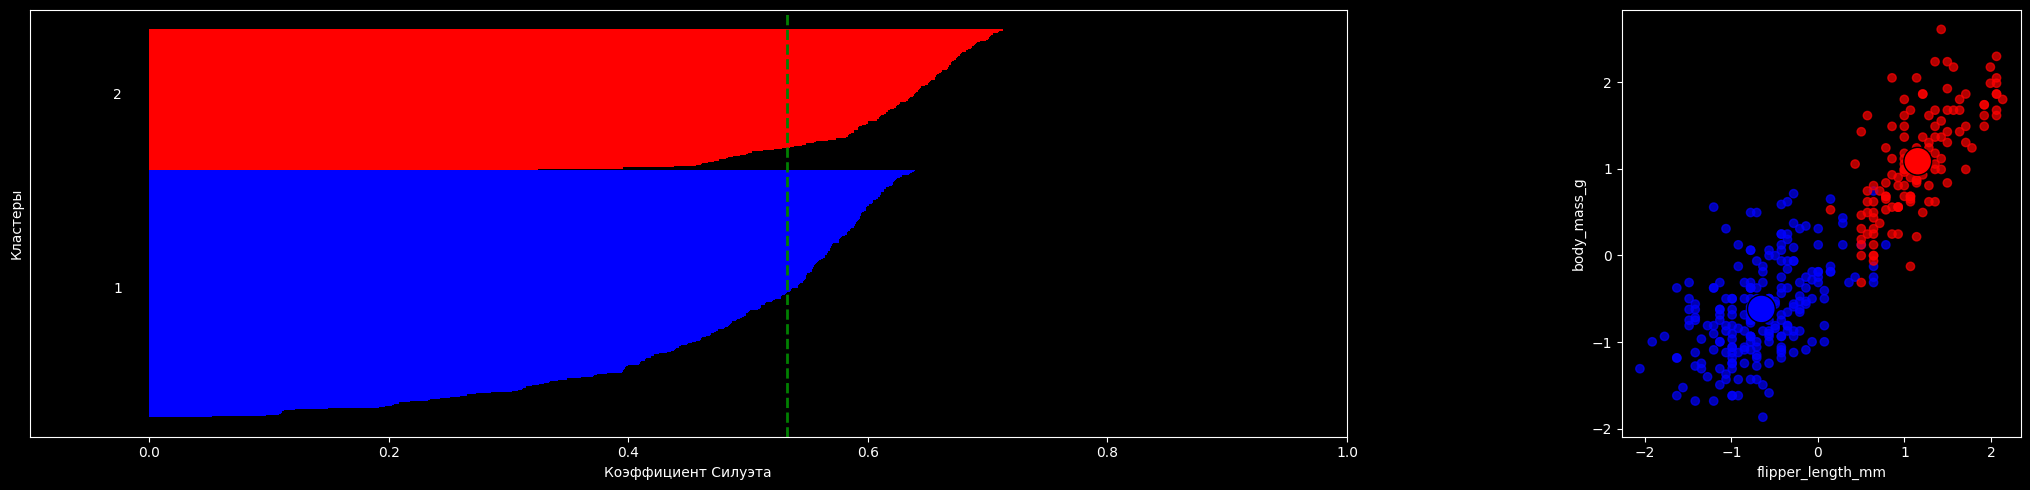

In [26]:
k = 2 

axis = [[0,1],
        [2,1],
        [0,3],
        [2,3],]

for axi in axis:
    axis_x = axi[0] 
    axis_y = axi[1] 

    X = np.array(df_cluster)
    # создаем объект
    km = KMeans(n_clusters=k,
                n_init = 10)
    # обучаем на данных
    km.fit(X)
    # предсказываем метки кластеров для данных
    labels = km.predict(X)
    # "забираем" координаты центров
    centroids = km.cluster_centers_
    # предсказываем метки для центроидов
    label_centroids = km.predict(centroids)
    # Визуализация и данных, и коэффициентов силуэта
    plot_silhouette_results(X,centroids,
                            labels, label_centroids,
                            axis_x, axis_y)

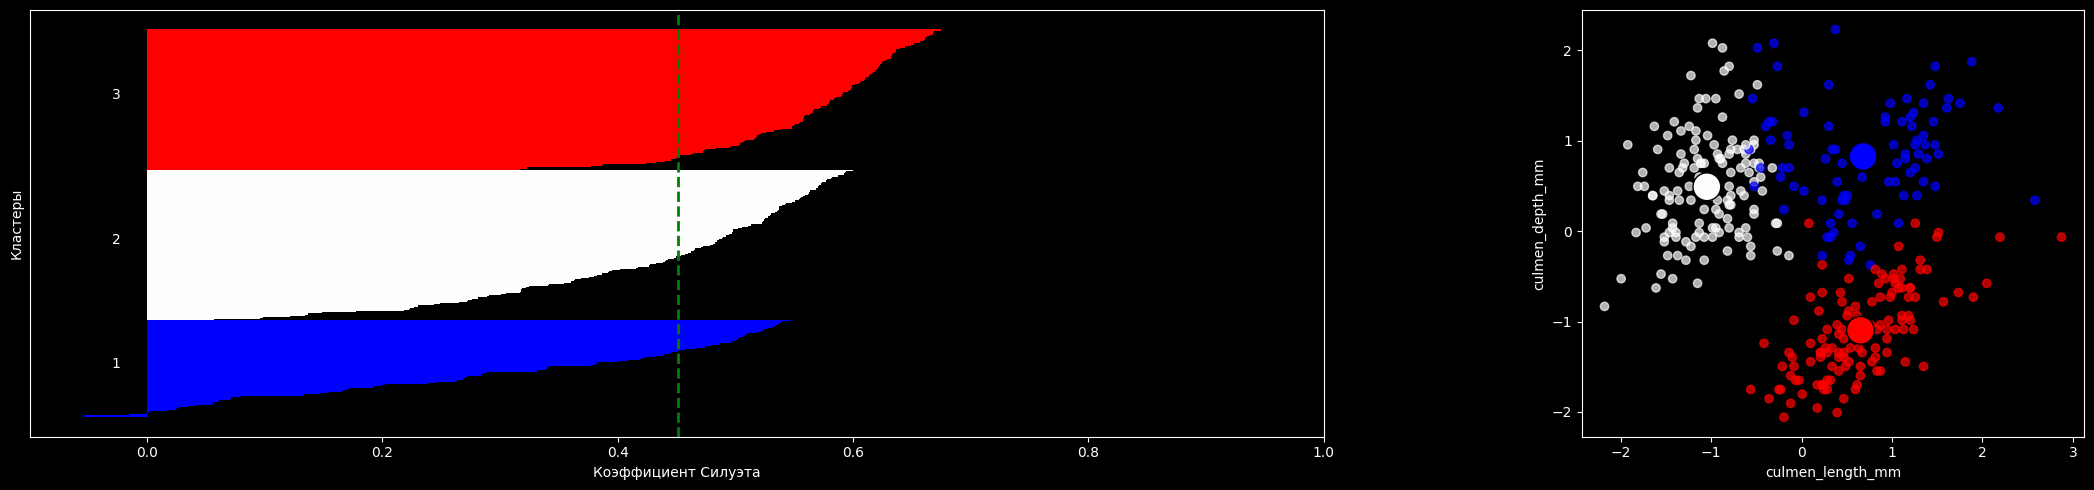

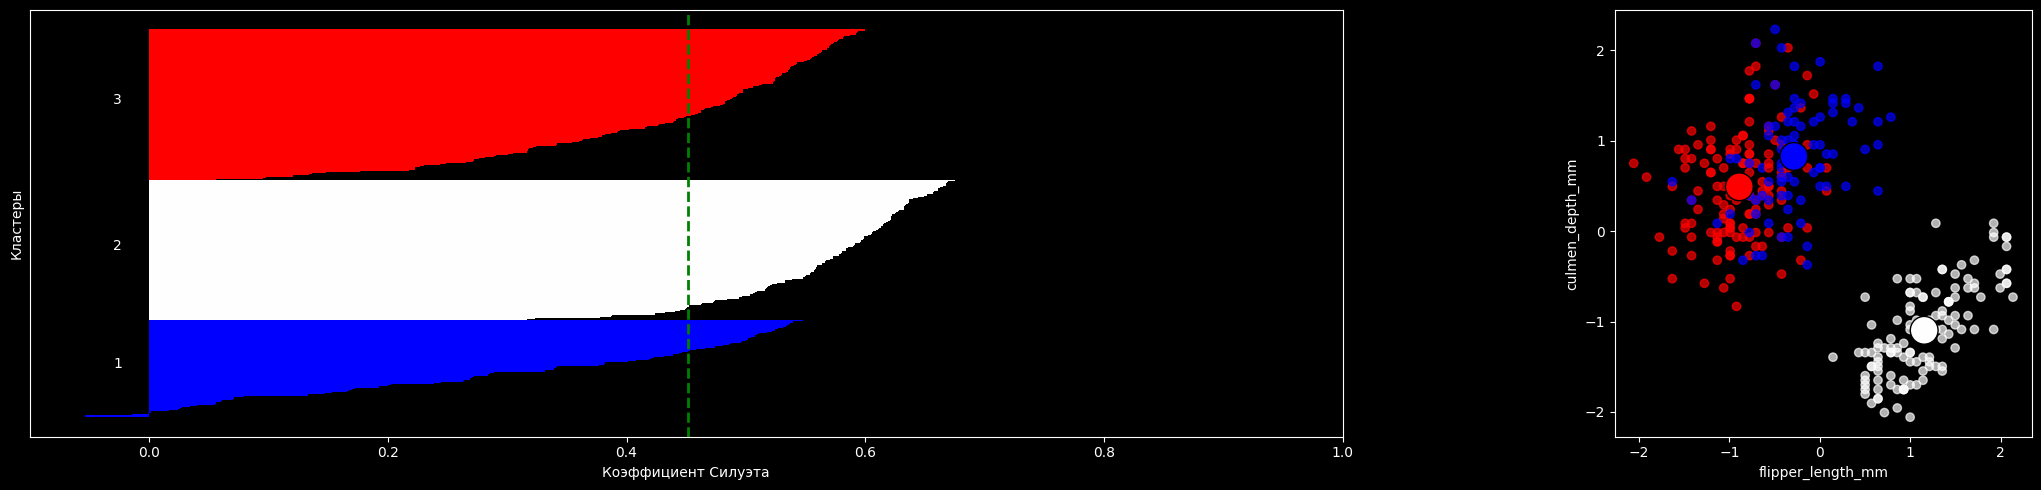

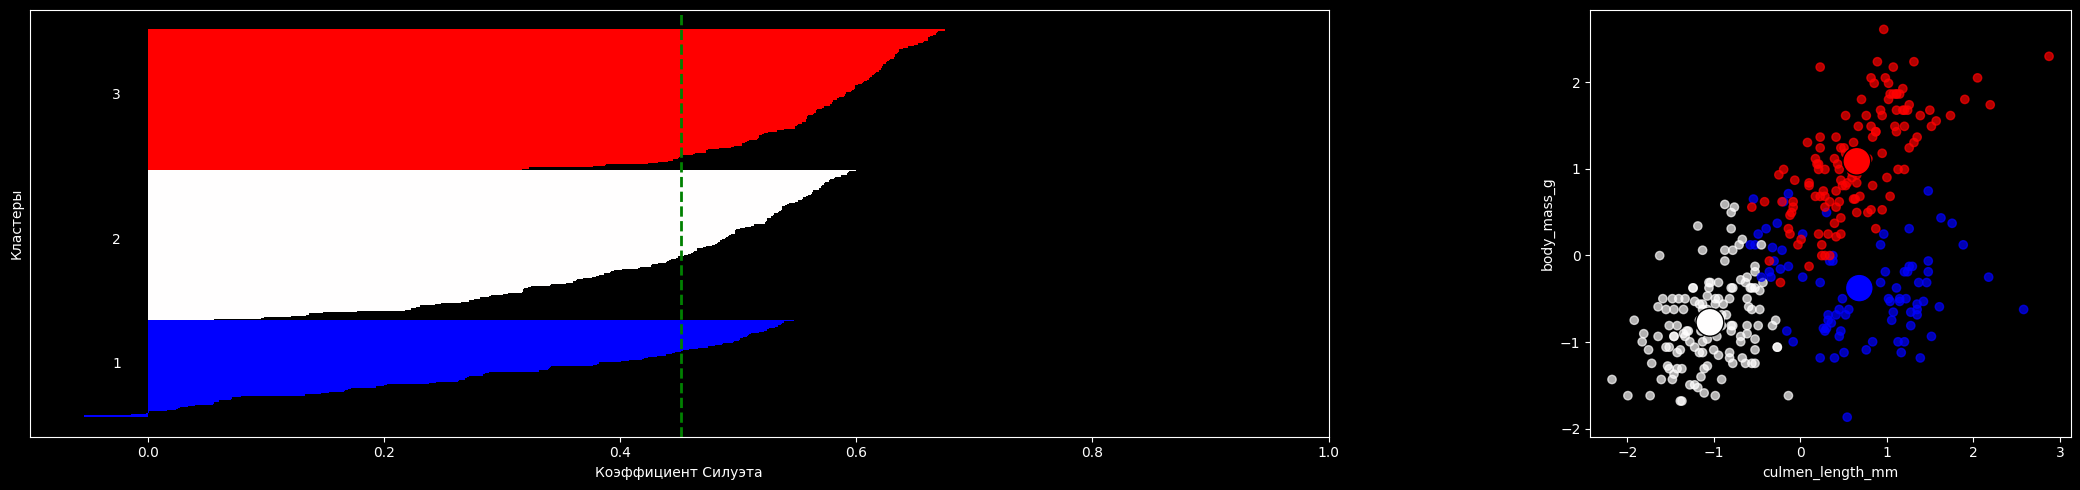

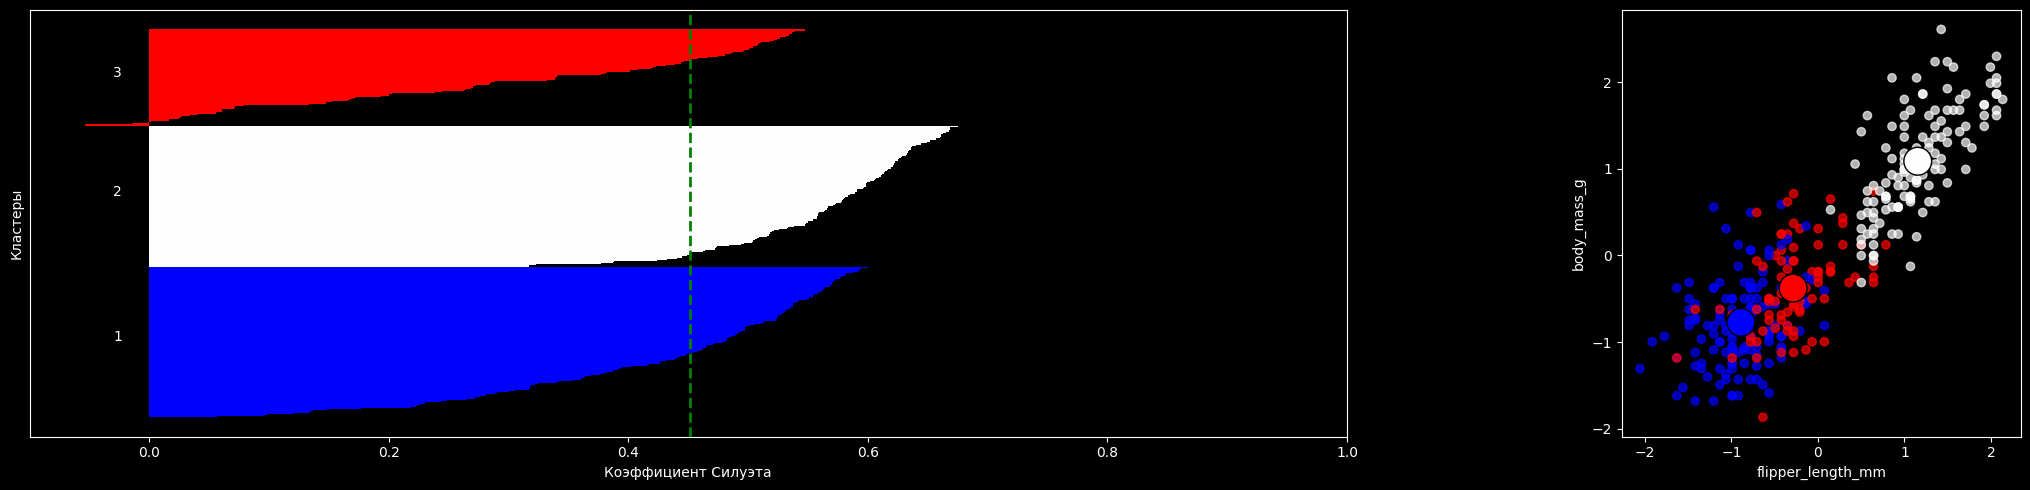

In [27]:
k = 3 

axis = [[0,1],
        [2,1],
        [0,3],
        [2,3],]

for axi in axis:
    axis_x = axi[0] 
    axis_y = axi[1] 

    X = np.array(df_cluster)
    # создаем объект
    km = KMeans(n_clusters=k,
                n_init = 10)
    # обучаем на данных
    km.fit(X)
    # предсказываем метки кластеров для данных
    labels = km.predict(X)
    # "забираем" координаты центров
    centroids = km.cluster_centers_
    # предсказываем метки для центроидов
    label_centroids = km.predict(centroids)
    # Визуализация и данных, и коэффициентов силуэта
    plot_silhouette_results(X,centroids,
                            labels, label_centroids,
                            axis_x, axis_y)

#### Выводы:
1) коэффициент силуэта также показывает, что для "culmen_length_mm/culmen_depth_mm" и "culmen_length_mm/body_mass_g" больше подходит разбиение на 3 кластера;
2) а зависимости  "flipper_length_mm/culmen_depth_mm" и "flipper_length_mm/body_mass_g" больше подходит 2 кластера

## 6) Связь между кластерами и категориальным признаком

Так как колонка "sex" имеет только 2 значения, то воспользуемся кластеризацией на 2 признака. Повторим визуализацию на 2 кластера:

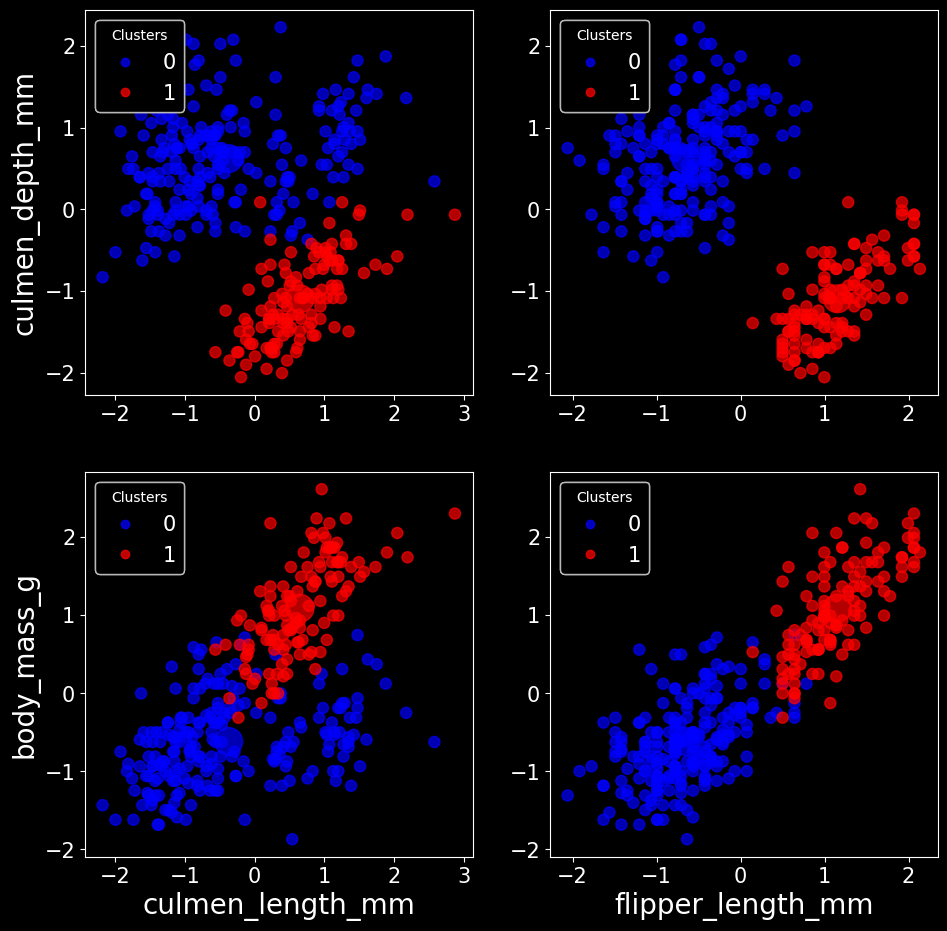

In [28]:
k = 2
X = np.array(df_cluster)
column_labels = df_cluster.columns
new_names = num_columns

# создаем объект
km = KMeans(n_clusters=k, n_init = 10)

# обучаем на данных
km.fit(X)
# предсказываем метки кластеров для данных
labels = km.predict(X)
# "забираем" координаты центров
centroids = km.cluster_centers_
# предсказываем метки для центроидов
label_centroids = km.predict(centroids)

#Визуализация 4-х проекций данных
fig, sub = plt.subplots(2, 2, figsize = (11,11))
plot_multi(X, labels,
           column_labels,
           sub, size = 64);


plot_multi(centroids, label_centroids,
           column_labels,
           sub, size = 400);

Теперь визуализируем колонку "sex":

In [29]:
# Приводим целевую переменную к 0 и 1
Label = LabelEncoder()
Label.fit(df["sex"]) # задаем столбец, который хотим преобразовать
Label.classes_ # в аттрибуте .classes_ хранится информация "какой класс как шифруется"

array(['.', 'FEMALE', 'MALE', nan], dtype=object)

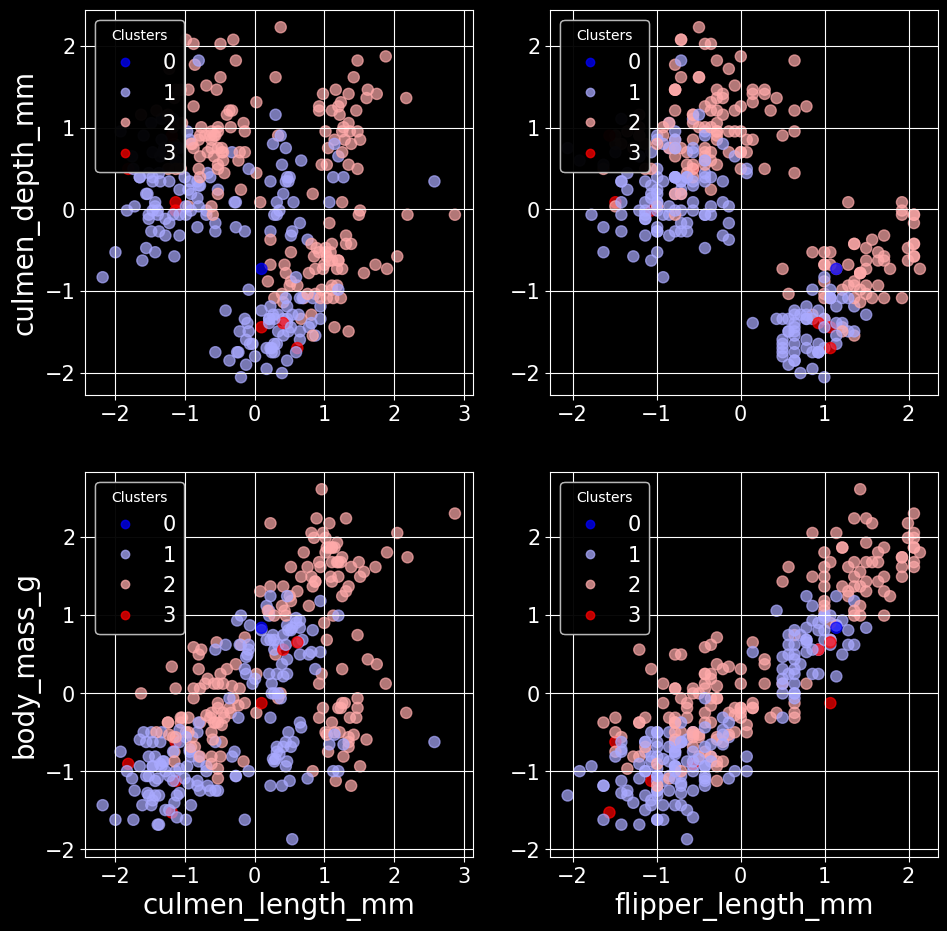

In [30]:
# sns.scatterplot(data=tips, x="total_bill", y="tip", hue="time")

X = np.array(df_cluster)
column_labels = df_cluster.columns
new_names = num_columns

# метки категоирального признака
labels = Label.transform(df["sex"]) 

#Визуализация 4-х проекций данных
fig, sub = plt.subplots(2, 2, figsize = (11,11))
plot_multi(X, labels,
           column_labels,
           sub, size = 64);


#### Выводы:
1) из визуализаций видно, что 2 кластера разбиваются не по "половому" признаку, а находит другое общее сходство у пингвинов)
2) "красные" метки пола (3 - nan) можно отнести к метке "1" (FEMALE);
3) единственную "синию" метку пола (0 - ".") ближе относится к метке "2" (MALE);
4) еще одно замечание, что если разделить каждый кластер еще на 2, т.е. использовать n_cluster = 4, то разбиение будет больше подходить по полу, только считать классы 0 и 2, 1 и 3 за один и тот же класс (см. ниже)

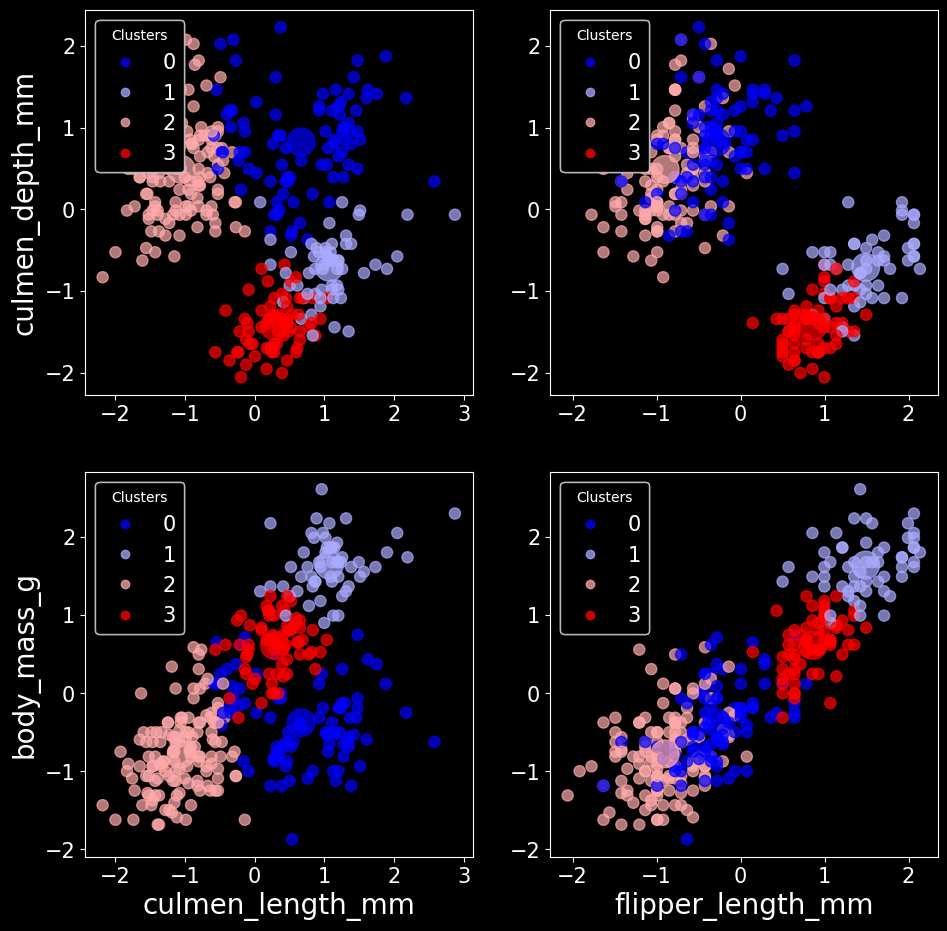

In [31]:
k = 4
X = np.array(df_cluster)
column_labels = df_cluster.columns
new_names = num_columns

# создаем объект
km = KMeans(n_clusters=k, n_init = 10)

# обучаем на данных
km.fit(X)
# предсказываем метки кластеров для данных
labels = km.predict(X)
# "забираем" координаты центров
centroids = km.cluster_centers_
# предсказываем метки для центроидов
label_centroids = km.predict(centroids)

#Визуализация 4-х проекций данных
fig, sub = plt.subplots(2, 2, figsize = (11,11))
plot_multi(X, labels,
           column_labels,
           sub, size = 64);


plot_multi(centroids, label_centroids,
           column_labels,
           sub, size = 400);

In [32]:
# попробуем посчитать метрику классификации таким способом
y_pred = labels
y_pred[y_pred == 2] = 0 # объединяем кластеры 0 и 2
y_pred[y_pred == 3] = 1 # объединяем кластеры 1 и 3

In [33]:
Label = LabelEncoder()
Label.fit(df["sex"]) 
y_true = Label.transform(df["sex"]) 
Label.classes_

array(['.', 'FEMALE', 'MALE', nan], dtype=object)

In [34]:
y_true[y_true == 2] = 0 # Male
y_true[y_true == 3] = 1 # Female

In [35]:
print(f"F1 метрика: {f1_score(y_true, y_pred):.4f}")

F1 метрика: 0.4136


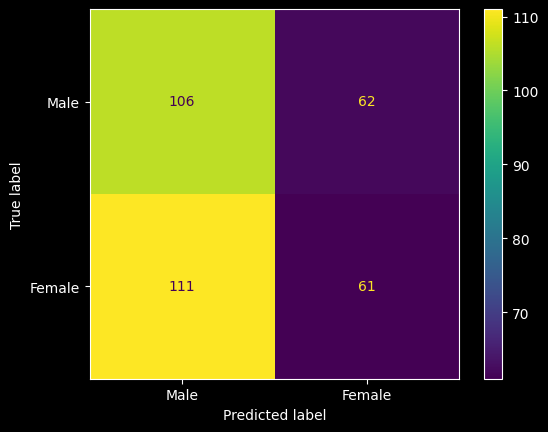

In [36]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Male', 'Female'])
disp.plot()
plt.show()

In [37]:
print(classification_report(y_true, y_pred, target_names=['Male', 'Female']))

              precision    recall  f1-score   support

        Male       0.49      0.63      0.55       168
      Female       0.50      0.35      0.41       172

    accuracy                           0.49       340
   macro avg       0.49      0.49      0.48       340
weighted avg       0.49      0.49      0.48       340



#### Выводы:
1) Данный способ и подход неплохо смог классифицировать "пол" пингвинов, метрика F1 = 0.7622. 